<a href="https://colab.research.google.com/github/pcbl/DeepDriver/blob/master/LearnPython/Jupyter/TrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Cloning a repo with German Signs!
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs
#the .CSV contains the classes and meaning of the sign
#The .p are so called pickle files are actually serialized python data we can deserialize and use

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd #used to read the csv on our case
import random

Using TensorFlow backend.


In [4]:
np.random.seed(0)

In [5]:
#Reading the Pickle Data!

#rb = Read + Binary

#Train Data
with open('german-traffic-signs/train.p', mode='rb') as f:
  train_data = pickle.load(f)

#Validation Data
with open('german-traffic-signs/valid.p', mode='rb') as f:
  val_data = pickle.load(f)

#Test Data
with open('german-traffic-signs/test.p', mode='rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape) # 34k Train data...
print(X_val.shape) # 4.4k Validation...
print(X_test.shape) # 12k test data...

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
#Ensure that labels does match the images...
assert(X_train.shape[0] == y_train.shape[0]), "Train: The number of images does not match to the number of labels!!!"
assert(X_val.shape[0] == y_val.shape[0]), "Validation: The number of images does not match to the number of labels!!!"
assert(X_test.shape[0] == y_test.shape[0]), "Test: The number of images does not match to the number of labels!!!"
#Ensure that the images are on the expected size
assert(X_train.shape[1:] == (32,32,3)),"Train:The dinamensions of the image are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)),"Validation:The dinamensions of the image are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)),"Test:The dinamensions of the image are not 32 x 32 x 3"

In [8]:
#We will use pandas to import the csv
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

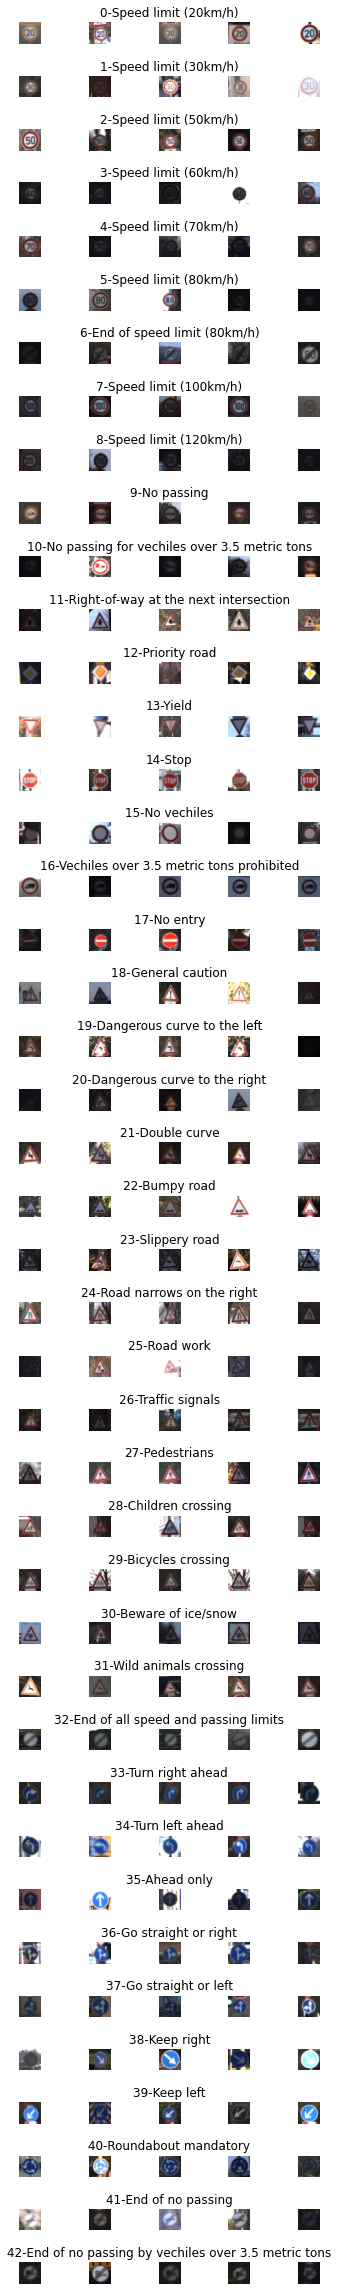

In [10]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 32))
fig.tight_layout()
for i in range(cols):
    #(index, Series) is the structure that iterrows() returns... 
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

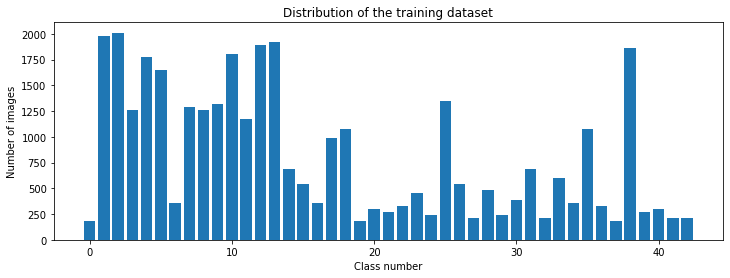

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36
Go straight or right


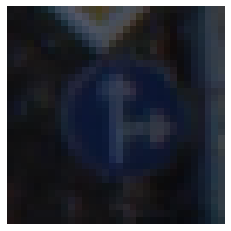

In [12]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
print(data.loc[y_train[1000],"SignName"])


(32, 32)


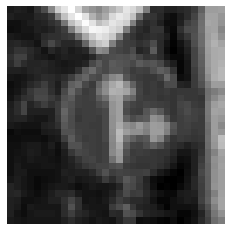

In [13]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")

print(img.shape)

(32, 32)


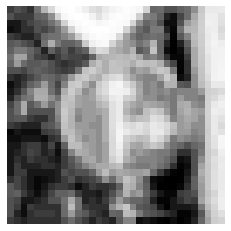

In [14]:
#Equalize to improve lighting within the grayscale image
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

In [15]:
def preprocess_image(img):
  img = grayscale(img)
  img = equalize(img)
  #normalizing the pixels to be between 0 and 1 to make model job easier
  img = img/255
  return img

X_train = np.array(list(map(preprocess_image, X_train)))
X_val = np.array(list(map(preprocess_image, X_val)))
X_test = np.array(list(map(preprocess_image, X_test)))



(34799, 32, 32)


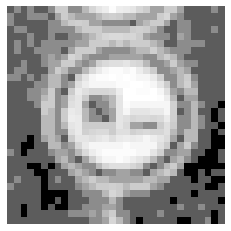

In [16]:
#Printing an random image...
plt.imshow(X_train[random.randint(0, len(X_train) -1)], cmap='gray')
plt.axis("off")
print(X_train.shape)

In [17]:
#Adding a depth, required by the Convolution neural Network(CNN)
X_train = X_train.reshape(X_train.shape[0],32,32,1)
X_test = X_test.reshape(X_test.shape[0],32,32,1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [18]:
#We add this preprocessing to "inflate" our sample data in order to improve score based on modified images
#Process called data augmentation!
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=.1, # 10% of image Width 
                             height_shift_range=.1, # 10% of image Height 
                             zoom_range=0.2, # 0.2 means 0.8(1-.2) Zoom Out and Zoom In of 1.2(1+.2)
                             shear_range=0.1,#distortion angle
                             rotation_range=10)# 10 degrees to rodate
datagen.fit(X_train)

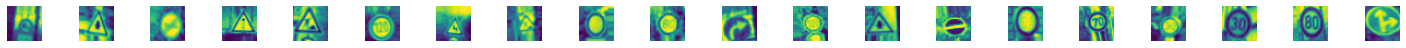

In [19]:
#we will use the dataflow to create batches of 20 new generated images
batches = datagen.flow(X_train,y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig,axs = plt.subplots(1,20, figsize=(20,5))
fig.tight_layout()
for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')


In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [21]:
#Hot encoding classes
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [25]:
#Steps to improve learning
# reduce learning rate from 0.01 to 0.001
# Increased Filters on first layer from 30 to 60
# Increased Filters on second layer from 15 to 30
# Added a second conv layer with 60
# Added a second conv layer with 30
# Added a Dropout layer the second Max Pooling...

def modified_model():
  model = Sequential()
  #30 Filters with 5x5 (our image is 32) = 5x5 x 30+30(Bias) = 780 parameters
  #Started with 30 and increased to 60 to improve accurracy
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))  
  #Added later to improve accuracy
  model.add(Conv2D(60, (5,5), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))
  
  #15 x 30 Depth x 9(3x3) parameters + 15 = 4065 parameters
  #Started with 15 and increased to 30 to improve accurracy
  model.add(Conv2D(30, (3,3), activation='relu'))
  #Added later for better performance
  model.add(Conv2D(30, (3,3), activation='relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Added later to reduce overfit
  #model.add(Dropout(0.5)) #Commented after added the image generator

  model.add(Flatten())
  #Now we forward the flatened aray to the fully conencted neural network
  model.add(Dense(500, activation='relu'))
  #the dropout will help us reducing overfitting!
  #Basically dropout will randomly shutdown nodes, forcing the network to use what it has...
  #We use a rate of 50% meaning that half of the nodes will be randomly shut down during the training
  model.add(Dropout(0.5))
  #Output layer, Finally... the outout is our # of classes.. softmax is important for classification...
  model.add(Dense(num_classes, activation='softmax'))  
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [26]:
model = modified_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

In [27]:
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)
#Now we use the generator
#Adding 50 generated images with the transformator thatw e built
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), verbose=1, shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.8845 - accuracy: 0.7414 - val_loss: 0.0656 - val_accuracy: 0.9828
Epoch 2/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.2143 - accuracy: 0.9323 - val_loss: 0.0702 - val_accuracy: 0.9803
Epoch 3/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1398 - accuracy: 0.9554 - val_loss: 0.0494 - val_accuracy: 0.9862
Epoch 4/10
2000/2000 [==============================] - 59s 29ms/step - loss: 0.1136 - accuracy: 0.9649 - val_loss: 0.0296 - val_accuracy: 0.9914
Epoch 5/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0968 - accuracy: 0.9702 - val_loss: 0.0509 - val_accuracy: 0.9848
Epoch 6/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0850 - accuracy: 0.9737 - val_loss: 0.0340 - val_accuracy: 0.9909
Epoch 7/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.0704 - accuracy: 0.9784 - val_loss: 0.0400 -

Text(0.5, 0, 'epoch')

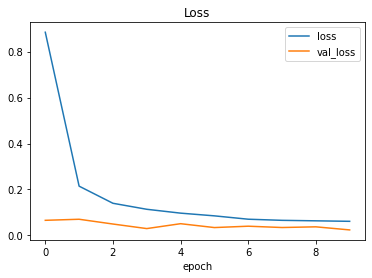

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

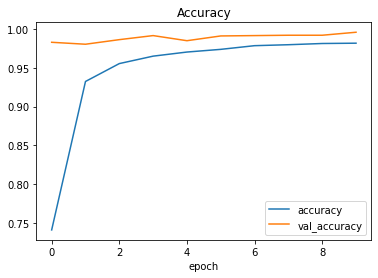

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [30]:
#Lets Test with the Test data and check the scores
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11098737669994035
Test accuracy: 0.9743468165397644


In [31]:
import requests
from PIL import Image
def test_image_from_web(url):
  fig = plt.figure()  
  #fetch image
  url = url
  r = requests.get(url, stream=True)
  img = Image.open(r.raw)
  a = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(img)#, cmap=plt.get_cmap('gray'))
  a.set_title('Original')

  #Preprocess image
  img = np.asarray(img)
  img = cv2.resize(img, (32, 32))
  img = preprocess_image(img)
  
  a = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(img, cmap = plt.get_cmap('gray'))

  #Reshape reshape
  img = img.reshape(1, 32, 32, 1)
  
  #Finally, Test image
  prediction = model.predict_classes(img)
  a.set_title(data.loc[prediction[0],"SignName"])  
  

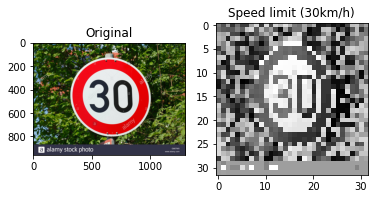

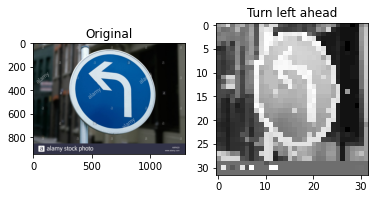

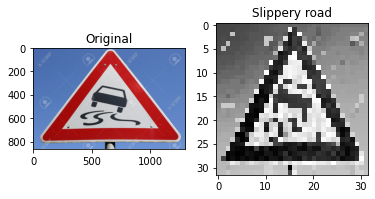

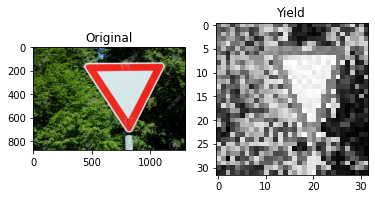

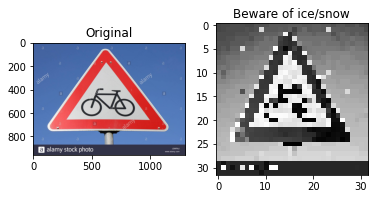

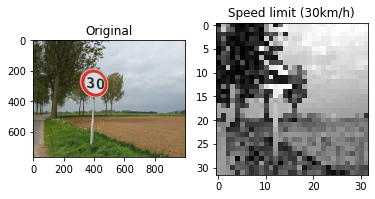

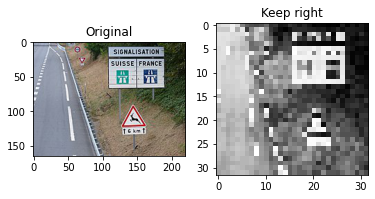

In [33]:
test_image_from_web('https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg')
test_image_from_web('https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg')
test_image_from_web('https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg')
test_image_from_web('https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg')
test_image_from_web('https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg')
test_image_from_web('https://archello.com/thumbs/images/2020/02/13/2017028-LR--1-.1581584122.5481.jpg')
test_image_from_web('https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/A411_panneaux_A15b_M2_signalisation_Suisse_France.jpg/220px-A411_panneaux_A15b_M2_signalisation_Suisse_France.jpg')